In [1]:
%matplotlib inline

import sys

import matplotlib.pyplot as plt

import os

import matplotlib as mpl

import numpy as np

from PIL import Image

from pyquaternion import Quaternion

import scipy

In [2]:
import sklearn

In [3]:
from scipy.optimize import linear_sum_assignment

In [4]:
sys.path.append("/home/nils/data_fusion/nuscenes-devkit/python-sdk")

In [5]:
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.3 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [6]:
from nuscenes.utils.data_classes import LidarPointCloud

from nuscenes.utils.geometry_utils import view_points


In [7]:
import sklearn.cluster

# Task 1

## Picking a random sample

In [8]:
def rotate_pointcloud(cloud, quaternion):
    def rot(an_array):
        return quaternion.rotate(an_array)
    return np.array(list(map(rot, cloud)))

In [9]:
def create_bounding_box(annotation_token):
    '''
    creates bounding box used for plotting
    '''
    van_annotation = nusc.get('sample_annotation', annotation_token)
    relativeboxvectors = [(van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0)]
    return np.array(relativeboxvectors), van_annotation['translation']

In [10]:
my_sample = nusc.sample[10]
my_scene_token =my_sample['scene_token']
my_scene = nusc.get('scene', my_scene_token)
first_sample_token = my_scene['first_sample_token']

In [11]:
#create list of sample tokens (of whole scene)
current_sample_token = first_sample_token
sample_tokens = []
while current_sample_token != '':
    sample_tokens.append(current_sample_token)
    #next annotaton token
    current_sample_token = nusc.get('sample', current_sample_token)['next']

In [12]:
def remove_clutter(sample_token):
    '''
    returns all points inside vehicle bounding boxes
    and the number of vehicle bounding boxes that actually contain measurements
    '''
    current_sample_from_scene = nusc.get('sample', sample_token)

    pointsensor_token = current_sample_from_scene['data']['LIDAR_TOP']
    pcl_path = nusc.get('sample_data', pointsensor_token)['filename']
    pc =LidarPointCloud.from_file(os.path.join('nuscenes',pcl_path))
    points = pc.points
    
    ego_pose = nusc.get('ego_pose', nusc.get('sample_data', pointsensor_token)['ego_pose_token'])
    

    calibrated_sensor_token = nusc.get('sample_data', pointsensor_token)['calibrated_sensor_token']
    calibrated_sensor = nusc.get('calibrated_sensor', calibrated_sensor_token)
    pointsensor_quaternion = Quaternion(calibrated_sensor['rotation'])
    ego_quaternion = Quaternion(ego_pose['rotation'])

    sensor_rotated_points = np.dot(pointsensor_quaternion.rotation_matrix, points[:3,:])
    rotated_points = np.dot(ego_quaternion.rotation_matrix, sensor_rotated_points)

    # use broadcasting to add translation to x and y dimension
    absolute_points = rotated_points+np.array(ego_pose['translation'][:3]).reshape(-1,1)
    
    all_annotation_points = np.empty([2, 0])
    vehicle_counter = 0
    for i in range(len(current_sample_from_scene['anns'])):

        current_annotation_token = current_sample_from_scene['anns'][i]
        current_annotation = nusc.get('sample_annotation', current_annotation_token)
        if current_annotation['category_name'][:7] != 'vehicle':
            continue

        #print(f'progress: {i/len(current_sample_from_scene["anns"])}')
        ### rotate points by inverse bounding box rotation (translation to its reference frame unnecessary for only filtering)
        reverse_annotation_quaternion = Quaternion(w=-1*current_annotation['rotation'][0], x=current_annotation['rotation'][1], y=current_annotation['rotation'][2], z=current_annotation['rotation'][3])
        points_bounding_rotation = np.dot(reverse_annotation_quaternion.rotation_matrix, absolute_points)

        #new stuff
        relativeboxvectors, position = create_bounding_box(current_annotation_token)

        rotated_box = relativeboxvectors+reverse_annotation_quaternion.rotate(position)

        x_max = rotated_box[:,0].max()
        x_min = rotated_box[:,0].min()

        y_max = rotated_box[:,1].max()
        y_min = rotated_box[:,1].min()

        ## Remove points that are outside the bounding box
        mask = np.ones(points_bounding_rotation.shape[1], dtype=bool)

        mask = np.logical_and(mask, points_bounding_rotation[0] > x_min)
        mask = np.logical_and(mask, points_bounding_rotation[0] < x_max)
        mask = np.logical_and(mask, points_bounding_rotation[1] > y_min)
        mask = np.logical_and(mask, points_bounding_rotation[1] < y_max)

        points_filtered_rotated = points_bounding_rotation[:,mask]
        if len(points_filtered_rotated[0])>0:
            vehicle_counter += 1
        ### rotate points back
        annotation_quaternion = Quaternion(current_annotation['rotation'])
        points_filtered_absolute = np.dot(annotation_quaternion.rotation_matrix, points_filtered_rotated)

        all_annotation_points = np.concatenate((all_annotation_points,points_filtered_absolute[:2]),axis=1)
    return all_annotation_points, vehicle_counter

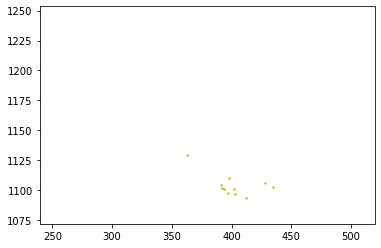

In [13]:
# go over whole scene and save cluster means for further calculations
ims = []
fig = plt.figure()
ax = fig.add_subplot(111)  # fig and axes created once
mean_positions_whole_scene = []
annotation_points_whole_scene = []
#clustering by kmeans
colors_whole_scene = []
# number of vehicles to cluster(only matters for kmeans)
vehicle_counters_whole_scene = []
mean_positions_whole_scene_dbscan = []
colors_dbscan = []
# go over all samples of our scene

for current_sample_token in sample_tokens:
    # remove clutter
    all_annotation_points, vehicle_counter = remove_clutter(current_sample_token)
    annotation_points_whole_scene.append(all_annotation_points)
    vehicle_counters_whole_scene.append(vehicle_counter)
    
    # apply clustering algorithms
    ## k_means
    clustered = sklearn.cluster.k_means(np.swapaxes(all_annotation_points,0,1), vehicle_counter)
    mean_positions = clustered[0]
    colors = clustered[1]
    colors_whole_scene.append(colors)
    mean_positions_whole_scene.append(mean_positions)
    
    ## dbscan
    db = sklearn.cluster.DBSCAN(eps=1.5, min_samples=1).fit(np.swapaxes(all_annotation_points,0,1))

    dbscan_clustered = [[] for x in range((db.labels_).max()+1)]

    for i,point in enumerate(db.labels_):
        dbscan_clustered[point].append(all_annotation_points[:,i])
    mean_positions = []
    for cluster in dbscan_clustered:
        means = np.array(cluster).mean(axis=0)
        mean_positions.append(means)
    mean_positions_whole_scene_dbscan.append(mean_positions)
    colors_dbscan.append(db.labels_)
    
    # add plot of mean positions to movie
    ims.append(plt.scatter(np.swapaxes(mean_positions,0,1)[0],np.swapaxes(mean_positions,0,1)[1], s=2,).findobj())
ax.axis('equal')
ani = mpl.animation.ArtistAnimation(fig, ims, repeat=False)
ani.save('annotations_im.gif', writer='pillow')

In [14]:
def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

6

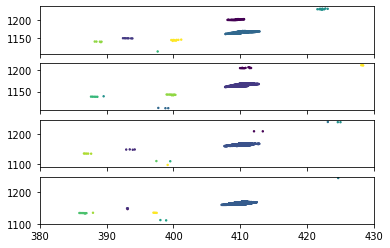

In [18]:
#use coloring of 
#clustered with k-means: colors_whole_scene 
#or dbscan: colors_dbscan

f, ax = plt.subplots(4,sharex=True)

i = 0
axes = plt.gca()
axes.set_xlim([380, 430])
axes.set_ylim([1100,1250])
#axes.axis('equal')
ax[i].scatter(annotation_points_whole_scene[i][0], annotation_points_whole_scene[i][1], c=colors_dbscan[i], s=2)
vehicle_counters_whole_scene[i]

i = 1
ax[i].scatter(annotation_points_whole_scene[i][0], annotation_points_whole_scene[i][1], c=colors_dbscan[i], s=2)
vehicle_counters_whole_scene[i]

i = 2
ax[i].scatter(annotation_points_whole_scene[i][0], annotation_points_whole_scene[i][1], c=colors_dbscan[i], s=2)
vehicle_counters_whole_scene[i]

i = 3
ax[i].scatter(annotation_points_whole_scene[i][0], annotation_points_whole_scene[i][1], c=colors_dbscan[i], s=2)
vehicle_counters_whole_scene[i]

In [19]:
# select the mean-positions of dbscan over kmeans as it appears to be more reliable
preprocessed_positions = mean_positions_whole_scene_dbscan

In [21]:
# algorithm to match 2 sets of points
def assignment(estimated_points, measured_points, max_velocity):
    '''
    inputs are lists of np.array((x,y)) that do not need to match in length
    max_velocity in m/s
    returns vector of measurements that match the positions of the estimated points
    '''
    # create cost matrix based on distances of cluster means
    cost_matrix = np.zeros((len(estimated_points),len(measured_points)))
    for i in range(len(estimated_points)):
        for j in range(len(measured_points)):
            cost_matrix[i,j] = distance(estimated_points[i],measured_points[j])

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    #create pointvector for further iteration (measurements matched to estimated points)
    matched_positions = np.zeros((len(estimated_points),2))
    for i in range(len(row_ind)):
        matched_positions[row_ind[i]] = measured_points[col_ind[i]]

    #replace point with 0,0 if velocity higher than 15 (~100km/h)
    for i in range(len(matched_positions)):
        d = distance(matched_positions[i],estimated_points[i])
        if d > max_velocity/2:
            matched_positions[i] = np.array((0,0))
    return matched_positions

In [22]:
def prediction_step(state_vector, covariance_matrix, sigma_v, t):
    F = np.array(((1,0,t,0),(0,1,0,t),(0,0,1,0),(0,0,0,1)))
    transition_error = np.array((0.5*t**2, 0.5*t**2, t, t))
    Q = sigma_v**2*np.dot(transition_error.reshape(-1,1),transition_error.reshape(-1,1).T)
    
    state_vector_next = np.dot(F, state_vector)
    C_next = np.dot(np.dot(F, covariance_matrix), F.T) + Q
    return state_vector_next, C_next

In [23]:
def measuring_step(state_vector, C, measurement, R):
    H = np.array(((1, 0, 0, 0), (0,1,0,0)))
    S = np.dot(np.dot(H,C), H.T) + R
    K = np.dot(np.dot(C, H.T), np.linalg.inv(S))
    C_next = C - np.dot(np.dot(K, S),K.T)
    #print(f'state vector: {state_vector} rest: {np.dot(K,np.array(measurement) - np.dot(H, state_vector))}')
    state_vector_next = state_vector + np.dot(K,np.array(measurement) - np.dot(H, state_vector))
    return state_vector_next, C_next

In [26]:
def run_filter_single_step(C,sigma_v,R, state_vector, measurement):
    state_vector, C = measuring_step(state_vector, C, measurement, R)
    state_vector, C = prediction_step(state_vector, C, sigma_v, t = 0.5)
    
    #state_vector, C = measuring_step(state_vector, C, measurement[:2], R)
    #state_vector, C = prediction_step(state_vector, C, sigma_v, t = measurement[2])
    return state_vector, C

In [25]:
from random import randint
colors = []

for i in range(7):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

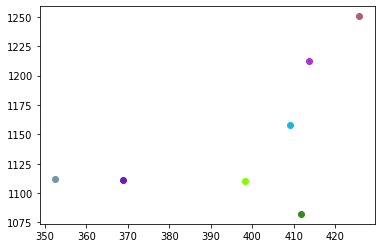

In [27]:
## initialize Covariance Matrix and state vector
# needs preprocessed_positions which are centers of clusters
max_velocity = 20 #m/s

sigma_v= 0.01
r = 1
R = np.array(((r,0),(0,r)))

estimated_states = []
covariance_matrices = []
for i in range(len(preprocessed_positions[0])):
    initial_position = preprocessed_positions[0][i]#accepted_initial_positions[0]
    initial_velocity = np.zeros(2)#accepted_initial_velocities[0]
    state_vector = np.append(initial_position,initial_velocity)

    C = 1*np.eye(4)
    C[2,2] = 10
    C[3,3] = 10

    estimated_state, C = prediction_step(state_vector, C, sigma_v, t = 0.5)
    
    estimated_states.append(estimated_state)
    covariance_matrices.append(C)
#iterate over all measurements
ims = []
fig = plt.figure()
ax = fig.add_subplot(111)
N = 38

for n in range(N):#len(preprocessed_positions)-1
    #match points
    estimated_points = np.array(estimated_states)[:,:2]#preprocessed_positions[n]
    measured_points = preprocessed_positions[n+1]

    matched_positions = assignment(estimated_points, measured_points, max_velocity)
    #kalman filter
    for i in range(len(matched_positions)):
        C = covariance_matrices[i]
        measurement = matched_positions[i]
        estimated_state = estimated_states[i]
        if measurement[0] == 0:
            estimated_state = np.array((0,0,0,0))
            continue
        state_vector, C = run_filter_single_step(C,sigma_v,R, estimated_state, measurement)

        covariance_matrices[i] = C
        estimated_states[i] = state_vector
    plotlist = []
    for i,point in enumerate(estimated_states):
        #print(point[3])
        if point[3] != 0:
            plotlist.append(plt.scatter(point[0], point[1], c = colors[i]).findobj()[0])
#ax[n].
    ims.append(plotlist)
ani = mpl.animation.ArtistAnimation(fig, ims, repeat=False)
ani.save('mult_t_tracking.gif', writer='pillow')

# some plots

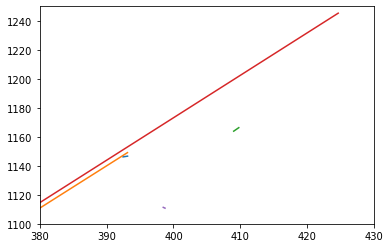

In [19]:
axes = plt.gca()
axes.set_xlim([380, 430])
axes.set_ylim([1100,1250])
for i in range(len(row_ind)):
    x = [estimated_points[i][0],matched_positions[i][0]]
    y = [estimated_points[i][1],matched_positions[i][1]]
    plt.plot(x,y)

In [20]:
for i in range(len(row_ind)):
    x = [preprocessed_positions[n][row_ind[i]][0],preprocessed_positions[n+1][col_ind[i]][0]]
    y = [preprocessed_positions[n][row_ind[i]][1],preprocessed_positions[n+1][col_ind[i]][1]]
    
    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[1], y[1]])
    ## throw out everything with velocity > 100km/h
    if distance(p1,p2) < 15:
        accepted_initial_positions.append(p2)
        accepted_initial_velocities.append((p2-p1)/2)

NameError: name 'accepted_initial_positions' is not defined

In [ ]:
print(f'error:{squared_distance(estimated_positions, cleaned_measurements)}')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot([pos[0] for pos in estimated_positions], [pos[1] for pos in estimated_positions])
plt.plot([pos[0] for pos in cleaned_measurements], [pos[1] for pos in cleaned_measurements])
ax.axis('equal')
plt.savefig('small_sigma_v.pdf')

In [ ]:
#preprocessed_positions = mean_positions_whole_scene
preprocessed_positions = mean_positions_whole_scene_dbscan#np.array()
n = 0
cost_matrix = np.zeros((len(preprocessed_positions[n]),len(preprocessed_positions[n+1])))
    for i in range(len(preprocessed_positions[n])):
        for j in range(len(preprocessed_positions[n+1])):
            cost_matrix[i,j] = distance(preprocessed_positions[n][i],preprocessed_positions[n+1][j])
# algorithm to match 2 sets of points
row_ind, col_ind = linear_sum_assignment(cost_matrix)
## get initial velocities and positions

accepted_initial_positions = []
accepted_initial_velocities = []
for i in range(len(row_ind)):
    x = [preprocessed_positions[n][row_ind[i]][0],preprocessed_positions[n+1][col_ind[i]][0]]
    y = [preprocessed_positions[n][row_ind[i]][1],preprocessed_positions[n+1][col_ind[i]][1]]
    
    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[1], y[1]])
    ## throw out everything with velocity > 100km/h
    if distance(p1,p2) < 15:
        accepted_initial_positions.append(p2)
        accepted_initial_velocities.append((p2-p1)/2)
    #print(f'p1: {p1}, p2: {p2}, distance: {distance(p1,p2)}')
    axes = plt.gca()
    axes.set_xlim([380, 430])
    axes.set_ylim([1100,1250])
    plt.plot(x,y)

In [ ]:
i = 2
x = np.swapaxes(mean_positions_whole_scene_dbscan[i],0,1)[0]
y = np.swapaxes(mean_positions_whole_scene_dbscan[i],0,1)[1]
axes = plt.gca()
axes.set_xlim([380, 430])
axes.set_ylim([1100,1250])
plt.scatter(x,y, c='red', s=5)

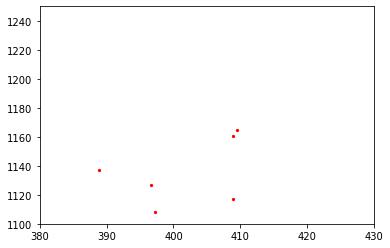

In [135]:
i = 8
x = np.swapaxes(mean_positions_whole_scene[i],0,1)[0]
y = np.swapaxes(mean_positions_whole_scene[i],0,1)[1]
axes = plt.gca()
axes.set_xlim([380, 430])
axes.set_ylim([1100,1250])
plt.scatter(x,y, c='red', s=5)

ValueError: 'c' argument has 1222 elements, which is inconsistent with 'x' and 'y' with size 2035.

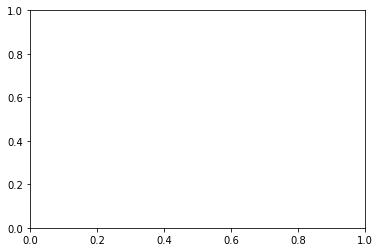

In [131]:
plt.scatter(annotation_points_whole_scene[i][0], annotation_points_whole_scene[i][1], s=0.1,c=db.labels_)

In [ ]:
#k-means with clutter
a = sklearn.cluster.k_means(np.swapaxes(pc.points[:2],0,1), len(first_sample_from_scene['anns']))

plt.scatter(pc.points[0], pc.points[1], s=0.1,c=a[1])